## implementation
[alg. lepesek](https://discourse.processing.org/t/wave-collapse-function-algorithm-in-processing/12983)


[interaktiv alg](https://oskarstalberg.com/game/wave/wave.html)

In [1]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from random import choices
%matplotlib inline
%config InlineBackend.figure_format ='svg'
from PIL import Image
import requests

### import bitmap

### load bitmap from url

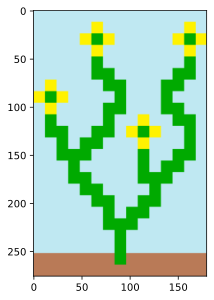

In [144]:
circle_url = "https://github.com/BitwiseSupernova/wave-function-collapse/raw/master/waveSource.png"
big_flower_url = "https://www.gridbugs.org/images/wave-function-collapse/flower-banner-scaled.png"
flower_url = "https://www.gridbugs.org/images/wave-function-collapse/flowers.png"



im = Image.open(requests.get(flower_url, stream=True).raw)
bitmap = np.asarray(im)
plt.imshow(bitmap)

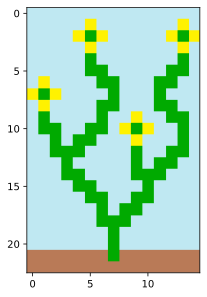

In [153]:
imr = im.resize((15,23), resample=Image.NEAREST)
bitmapr = np.asarray(imr)
plt.imshow(bitmapr)

In [154]:
bitmap = bitmapr

### load bitmap from file


In [107]:
bitmap_fp = "flowers.png"
# bitmap_fp = "circle.png"
# bitmap_fp = "flower-banner-scaled.png"
with Image.open(bitmap_fp) as im:
    bitmap = np.asarray(im)

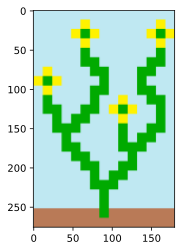

In [108]:
plt.imshow(np.asarray(Image.open(bitmap_fp)))

In [109]:
bitmap = np.asarray(  Image.open(bitmap_fp).resize((15,23), resample = Image.Resampling.NEAREST) )

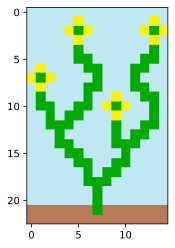

In [110]:
plt.imshow(  bitmap  )

In [111]:
bitmap.shape

(23, 15, 3)

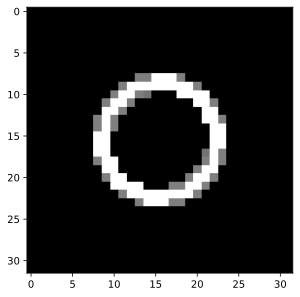

In [103]:
plt.imshow(bitmap)

### tile scan, tile id, and tile count

In [112]:
def get_tiles(image):
  """
  scan (3,3,3) patterns.
  """
  aa = np.hstack([image,image])
  aaaa = np.vstack([aa,aa])

  tiles = []

  for x in range(bitmap.shape[0]):
    for y in range(bitmap.shape[1]):
      # window upper left at (x,y)

      tile = aaaa[x:x+3,y:y+3,:]
      tiles.append(tile)

      
    
  return tiles


In [113]:
tiles = get_tiles(bitmap)
tile_hashes = [hash(t.data.tobytes()) for t in tiles]  
tile_counts = Counter(tile_hashes)
get_tile_from_hash = {h : t for h, t in zip(tile_hashes, tiles)}

### compute Adjacency rules

In [114]:
len(tile_counts)

95

In [115]:
test_id = -2613818574377563994

In [116]:
Adjacency_rules = {t_id : [set(),set(),set(),set()] for t_id in tile_counts}


for t_id in tile_counts:
  for nb_id in tile_counts:

    # 0. irany : nyugat, bal -----------------------------
    a = get_tile_from_hash[t_id][:,:2,:]
    b = get_tile_from_hash[nb_id][:,1:,:]

    if np.all(a == b): #ha atfedesben van
      Adjacency_rules[t_id][0].add(nb_id)

    # 1. irany : kelet, jobb -----------------------------
    a = get_tile_from_hash[t_id][:,1:,:]
    b = get_tile_from_hash[nb_id][:,:2,:]

    if np.all(a == b): #ha atfedesben van
      Adjacency_rules[t_id][1].add(nb_id)

    # 2. irany : eszak, fel -----------------------------
    a = get_tile_from_hash[t_id][:2,:,:]
    b = get_tile_from_hash[nb_id][1:,:,:]

    if np.all(a == b): #ha atfedesben van
      Adjacency_rules[t_id][2].add(nb_id)

    # 3. irany : del, le -----------------------------
    a = get_tile_from_hash[t_id][1:,:,:]
    b = get_tile_from_hash[nb_id][:2,:,:]

    if np.all(a == b): #ha atfedesben van
      Adjacency_rules[t_id][3].add(nb_id)

In [117]:
nr_tiles = len(tile_counts)

# A : (melyik csempe, melyik szomszeddal, melyik iranyban) = szomszedos-e?
A = np.zeros((nr_tiles,nr_tiles,4), dtype = "bool")


for t_idx, t_id in enumerate(tile_counts):
  for nb_idx, nb_id in enumerate(tile_counts):
    a = get_tile_from_hash[t_id]
    b = get_tile_from_hash[nb_id]


    # 0. irany : nyugat, bal 
    if np.all(a[:,:2,:] == b[:,1:,:]): #ha atfedesben van
      A[t_idx, nb_idx, 0] = True

    # 1. irany : kelet, jobb 
    if np.all(a[:,1:,:] == b[:,:2,:]): 
      A[t_idx, nb_idx, 1] = True

    # 2. irany : eszak, fel 
    if np.all(a[:2,:,:] == b[1:,:,:]): 
      A[t_idx, nb_idx, 2] = True

    # 3. irany : del, le 
    if np.all(a[1:,:,:] == b[:2,:,:]): 
      A[t_idx, nb_idx, 3] = True


### creat output possibilities (`W`)

In [238]:
out_dims = (80,100)

In [239]:
id_to_idx = { id : n  for n, id in enumerate(tile_counts.keys()) }

In [240]:
W = np.ones((*out_dims, len(tile_counts)), dtype = "bool")

In [241]:
W.shape

(80, 100, 95)

### create entropy vec (`H`)

In [242]:
H = np.ones((out_dims), dtype = "float")

In [243]:
H[:,:] = len(tile_counts)

### observation

In [244]:
def observation(H, W):
  """
  1.find min entropy
  2.choose from possible tiles, according to input deviation

  returns (which index, what color)
  """
  #find min entropy
  i,j = np.unravel_index(H.argmin(), H.shape) # find argmin indices

  #choose from possible tiles, according to input deviation
  population = []
  weights = []
  for b, t_id in zip(W[i,j], id_to_idx):
    if b: # ha ez meg megengedett csempe
      population.append(t_id)
      weights.append(tile_counts[t_id])


  return (i,j), choices(population, weights=weights)[0]


### collapse, and create `output_image`

In [245]:
output_image = np.zeros((*out_dims, 3), dtype = "uint8")

In [246]:
def collapse(H,W, output_image):
  """
  1. get min entropy tile
  2. update W an H
  3. color output_image

  return the collapsed index (i,j)
  """

  #get min entropy tile 
  (i,j), t_id = observation(H, W) 

  #update W at this tile
  W[i,j, :] = False
  W[i,j, id_to_idx[t_id]] = True

  # set entropy to inf for the collapsed cell
  H[i,j] = float("inf")

  # color the (i,j) pixel in the output_image
  # with the left upper color of the coosen tile.
  output_image[i,j, :] = get_tile_from_hash[t_id][0,0,:] #

  return (i,j)

In [247]:
# for _ in range(6000):
#   collapse(H, W, output_image)

### propagation 🥸

In [248]:
def propagation(W, i,j):
  """
  start updating W from (i,j) using Adjacency_rules
  """
  
  stack = {(i,j)} #start from last recent collapsed cell

  while stack:

    idx_current = stack.pop() # a kozepso, akinek a szomszedait vizsgaljuk

    w,h = W.shape[1], W.shape[0]

    i,j = idx_current

    nbr_idxs = [(i, (j-1) % w), # 0. irany : nyugat, bal 
                (i, (j+1) % w), # 1. irany : kelet, jobb
                ((i-1) % h, j), # 2. irany : eszak, fel
                ((i+1) % h, j)  # 3. irany : del, le
                ]

    for dir, idx_nb in enumerate(nbr_idxs):

      if H[idx_nb] != float("inf"): #csak ha meg nem collapsed a nb
        
        possible_tiles_at_current = W[idx_current]
        
        possible_nbrs_at_dir = np.any( A[possible_tiles_at_current, :, dir],
                                      axis = 0)
        
        x,y = idx_nb
        available = W[x,y, :]

        # check if the neighbour is need to be updated at all
        # available is not subset of possible_nbrs_at_dir ?
        if not ( np.all( possible_nbrs_at_dir[available] )):

          intersection = possible_nbrs_at_dir & available

          if np.sum(intersection) == 0:
            print("nincs lehetseges csempe")
            return

          else:
            #update wave function at idx_nb
            W[x,y, :] = intersection

            # add nbr to stack
            stack.add(idx_nb)

In [249]:
from tqdm import trange

In [250]:
for t in trange(out_dims[0] * out_dims[1]):
  collapsed_idx = collapse(H,W, output_image)
  propagation(W, *collapsed_idx)
  update_entropy(H, W)

  if t % 100 == 0:
    # plt.imshow(output_image)
    # plt.savefig(f"gif/out_{t}.png")
    Image.fromarray(output_image).save(f"gif/out_{t}.png")

    
Image.fromarray(output_image).save(f"gif/out_{8000}.png")

 39%|██████████████▉                       | 3144/8000 [00:11<00:12, 403.32it/s]

nincs lehetseges csempe
nincs lehetseges csempe
nincs lehetseges csempe
nincs lehetseges csempe
nincs lehetseges csempe
nincs lehetseges csempe


 42%|███████████████▊                      | 3329/8000 [00:12<00:10, 461.46it/s]

nincs lehetseges csempe


100%|██████████████████████████████████████| 8000/8000 [00:21<00:00, 365.38it/s]


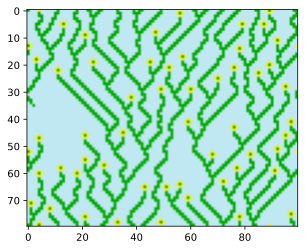

In [251]:
plt.imshow(output_image)
# plt.savefig("flowers_out.png")

In [236]:
images = [Image.open(f"gif/out_{t}.png") for t in range(0,8001, 100)]

In [237]:
images[0].save('flower_out2.gif',
               save_all=True,
               append_images=images[1:],
               optimize=True,
               duration=4, loop=0)

In [38]:
output_image.shape

(80, 100, 3)

In [65]:
propagation(W, 0,0)

(123,) (123,)


In [ ]:
    
    # [0,1,2,3]:
      
    #   i,j = idx_current

    #   if dir == 0: # 0. irany : nyugat, bal 
    #     idx_nb = i, (j-1) % W.shape[1]
    #   elif dir == 1: # 1. irany : kelet, jobb 
    #     idx_nb = i, (j+1) % W.shape[1]
    #   elif dir == 2: # 2. irany : eszak, fel
    #     idx_nb = (i - 1) % W.shape[0], j
    #   else:          # 3. irany : del, le
    #     idx_nb = (i + 1) % W.shape[0], j


    #   idx_nb = idx_current



### update entropy

In [53]:
def update_entropy(H, W):
  """
  update H from the new W.
  """
  finished = H == float("inf")
    
  H[:,:] = np.sum(W, axis = 2) + 0.1 * np.random.randn(*H.shape)

  H[finished] = float("inf")

In [ ]:
np.random.randn(2,2)